In [1]:
%matplotlib widget

In [2]:
# It seems no matter what I do I cant knock the total probability awaya from about 1, and total probability away from about 100, unlike the 2D simulation

In [3]:
'''
Author: Hadayat Seddiqi
Date: Feb. 28th, 2013
Description: n/a
'''

import scipy as sp
import numpy as np
from scipy import integrate, sparse, linalg
import scipy.sparse.linalg
#import pylab as pl

def Solve(gridParams, solver, niter, psi, pot, nonlin, imagTime):
    # Invoke the imaginary Crank-Nicolson solver
    if imagTime:
        nx = gridParams['nx']
        dx = gridParams['dx']
        dt = gridParams['dt']

        # Set up tridiagonal coefficients
        Adiag = np.empty(nx)
        Asup = np.empty(nx)
        Asub = np.empty(nx)
        bdiag = np.empty(nx)
        bsup = np.empty(nx)
        bsub = np.empty(nx)
        Adiag.fill(1 + dt/dx**2)
        Asup.fill(-dt/(2*dx**2))
        Asub.fill(-dt/(2*dx**2))
        bdiag.fill(1 - dt/dx**2)
        bsup.fill(dt/(2*dx**2))
        bsub.fill(dt/(2*dx**2))

        # Construct tridiagonal matrix
        A = sp.sparse.spdiags([Adiag, Asup, Asub], [0, 1, -1], nx, nx)
        b = sp.sparse.spdiags([bdiag, bsup, bsub], [0, 1, -1], nx, nx)

        # Loop through time
        for t in range(0, niter) :
            # Calculate effect of potential and nonlinearity
            psi = np.exp(-dt*(pot + nonlin*psi*psi))*psi

            # Calculate spacial derivatives
            psi = np.sparse.linalg.bicg(A, b*psi)[0]

            # Normalize Psi
            psi /= np.sqrt(sp.integrate.simps(psi*psi, dx=dx))

            # Output figures
            gridx = dx*(sp.arange(nx) - nx/2)
            xlimit = [gridx[0], gridx[-1]]
            ylimit = [0, 1]
            pl.plot(gridx, psi)
            pl.plot(gridx, psi*psi)
            pl.plot(gridx, pot)
            pl.xlim(xlimit)
            pl.ylim(ylimit)
            pl.savefig('outputlaim/fig' + str(t))
            pl.clf()

        return psi
    # Real-time evolution with Crank-Nicolson
    else:
        nx = gridParams['nx']
        dx = gridParams['dx']
        dt = gridParams['dt']

        # Set up tridiagonal coefficients
        Adiag = np.empty(nx, dtype=sp.complex128)
        Asup = np.empty(nx, dtype=sp.complex128)
        Asub = np.empty(nx, dtype=sp.complex128)
        bdiag = np.empty(nx, dtype=sp.complex128)
        bsup = np.empty(nx, dtype=sp.complex128)
        bsub = np.empty(nx, dtype=sp.complex128)
        Adiag.fill(1 + 1j*dt/dx**2)
        Asup.fill(-1j*dt/(2*dx**2))
        Asub.fill(-1j*dt/(2*dx**2))
        bdiag.fill(1 - 1j*dt/dx**2)
        bsup.fill(1j*dt/(2*dx**2))
        bsub.fill(1j*dt/(2*dx**2))

        # Construct tridiagonal matrix
        A = sp.sparse.spdiags([Adiag, Asup, Asub], [0, 1, -1], nx, nx)
        b = sp.sparse.spdiags([bdiag, bsup, bsub], [0, 1, -1], nx, nx)
        psis = []
        # Loop through time
        for t in range(0, niter) :
            # Calculate effect of potential and nonlinearity
            psi = np.exp(-1j*dt*(pot + nonlin*np.absolute(psi,psi)**2))*psi

            # Calculate spacial derivatives
            psi = sp.sparse.linalg.bicg(A, b*psi)[0]

            # Output figures
            gridx = dx*(np.arange(nx) - nx/2)
            xlimit = [gridx[0], gridx[-1]]
            ylimit = [0, 1]
            psis.append(psi)
            #pl.plot(gridx, psi)
            #pl.plot(gridx, sp.absolute(psi,psi)**2)
            #pl.plot(gridx, pot)
            #pl.xlim(xlimit)
            #pl.ylim(ylimit)
            #pl.savefig('outputla/fig' + str(t))
            #pl.clf()

        return psis

In [4]:
def make_wave_packet(spatial_step : float, initial_x : float, standard_deviation : float, x_positions : np.array) -> np.array: 
    unnormalized = np.exp((-1 / ((standard_deviation ** 2))) * ((x_positions - initial_x) ** 2))
    normalization_value : float = np.sqrt((np.sum(unnormalized.real ** 2) + np.sum(unnormalized.imag ** 2)) * spatial_step)
    return unnormalized / normalization_value


In [5]:
def tunnel(x_positions, where, width, potential): 
    return np.where((x_positions > where) & (x_positions < (where + width)), potential, 0)

In [6]:
space_step = .01
length = 1
time_step = space_step ** 2 / 4
point_count = int(length / space_step)
x = space_step * (np.arange(point_count) - point_count / 2)
#space_step * (np.arange(point_count) - point_count / 2)
frame_count = 100000
potential = tunnel(x, .2, .1, 1)
psi = np.exp(-0.5*x**2)
#initial_wave_function = psi / np.sqrt(sp.integrate.simps(psi*psi, dx=space_step))
initial_wave_function = make_wave_packet(space_step, .0, .1, x)
result = Solve(
        {"nx" : point_count, "dx" : space_step, "dt" : time_step}, 
        None, 
        frame_count, 
        initial_wave_function, 
        potential, 
        0, 
        0
    )

In [7]:
from typing import List

In [8]:
from matplotlib import pyplot as plt

In [9]:
from matplotlib.animation import FuncAnimation

In [10]:
print(len(result))

100000


In [11]:
def animate1DPlot(x_limit : float, y_limit : float, pointCount : int, space_step : float, data : List[np.array], interval = 1): 
    animationFigure = plt.figure()
    animationAxis = animationFigure.add_subplot(xlim=(0, x_limit), ylim=(0, y_limit))
    x = np.arange(pointCount) * space_step
    animationFrame, = plt.plot(x, x * 0)
    def init(): 
        animationFrame.set_data(x, x * 0)
        return animationFrame, 
    def animateFrame(frameIndex): 
        animationFrame.set_data(x, data[frameIndex])
        animationFrame.set_zorder(1)
        return animationFrame,
    animation = FuncAnimation(
            animationFigure, 
            animateFrame, 
            interval=interval, 
            frames=np.arange(0, len(data)), 
            repeat = True, 
            blit = True, 
            init_func = init
        )
    return animation

In [12]:
probabilities = np.array([(psi.imag ** 2) + (psi.real ** 2) for psi in result]).astype(np.float64)

In [13]:
total_probabilities = [np.sum(probability_set) for probability_set in probabilities]

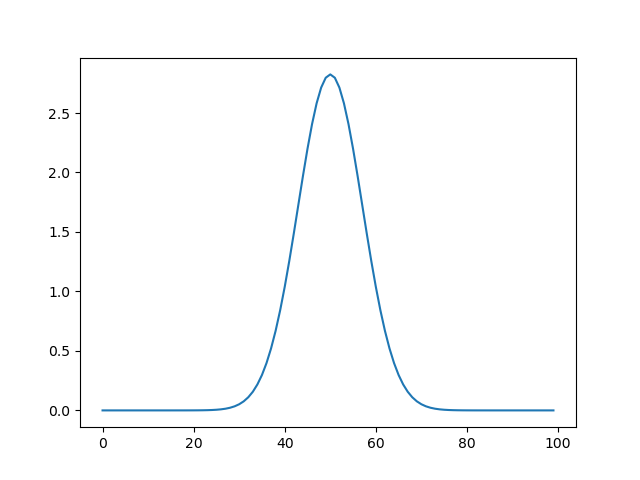

In [14]:
plt.figure()
plt.plot(initial_wave_function)

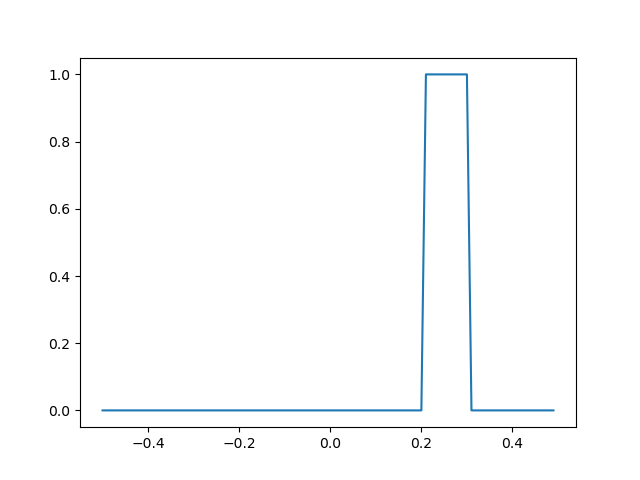

In [15]:
plt.figure()
plt.plot(x, potential)

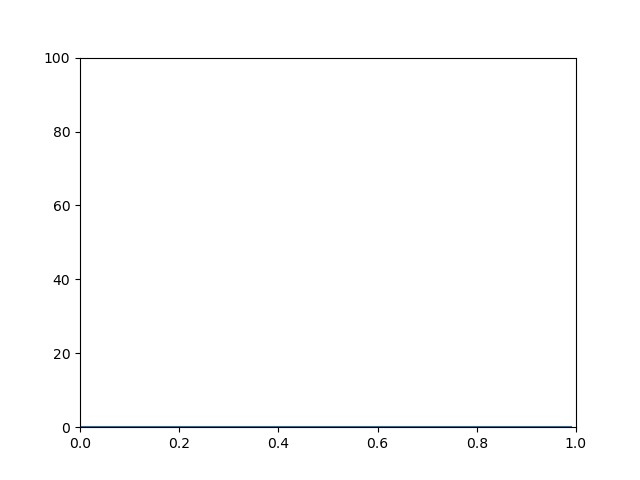

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
animate1DPlot(length, np.max(total_probabilities), point_count, space_step, probabilities, 1)

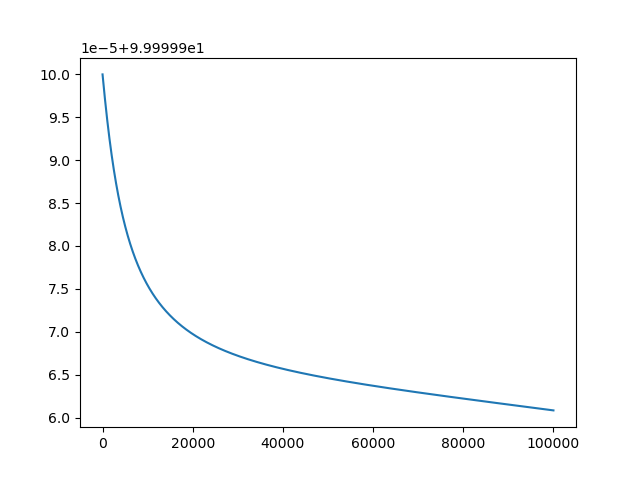

In [17]:
plt.figure()
plt.plot(total_probabilities)

In [18]:
total_probabilities

[99.99999999437172,
 99.9999999887444,
 99.99999998311799,
 99.99999997749254,
 99.99999997186801,
 99.99999996624442,
 99.99999996062176,
 99.99999995500005,
 99.99999994937922,
 99.99999994375935,
 99.99999993814043,
 99.99999993252241,
 99.99999992690533,
 99.99999992128922,
 99.99999991567404,
 99.99999991005978,
 99.99999990444647,
 99.99999989883409,
 99.99999989322266,
 99.99999988761218,
 99.99999988200263,
 99.99999987639401,
 99.99999987078635,
 99.99999986517962,
 99.99999985957382,
 99.99999985396899,
 99.99999984836509,
 99.99999984276214,
 99.99999983716009,
 99.99999983155902,
 99.9999998259589,
 99.99999982035969,
 99.99999981476144,
 99.99999980916414,
 99.99999980356776,
 99.99999979797235,
 99.99999979237789,
 99.99999978678437,
 99.99999978119178,
 99.99999977560013,
 99.99999977000944,
 99.99999976441967,
 99.99999975883087,
 99.999999753243,
 99.99999974765608,
 99.99999974207009,
 99.99999973648508,
 99.99999973090101,
 99.99999972531788,
 99.99999971973568,
 99.

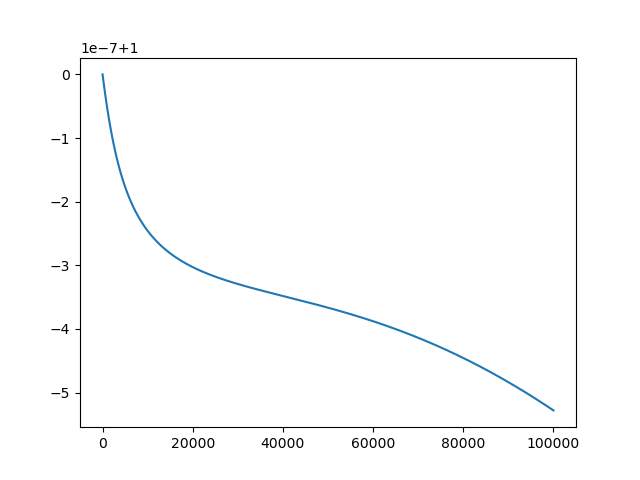

In [19]:
plt.figure()
normalized = [sp.integrate.simps((psi.real ** 2) + (psi.imag ** 2), dx=space_step) for psi in result]
plt.plot(normalized)

In [20]:
normalized

[0.9999999999437172,
 0.999999999887444,
 0.9999999998311802,
 0.9999999997749256,
 0.99999999971868,
 0.9999999996624442,
 0.9999999996062174,
 0.9999999995500004,
 0.9999999994937923,
 0.9999999994375934,
 0.9999999993814044,
 0.9999999993252242,
 0.9999999992690535,
 0.9999999992128923,
 0.9999999991567403,
 0.9999999991005977,
 0.9999999990444646,
 0.999999998988341,
 0.9999999989322268,
 0.9999999988761219,
 0.9999999988200263,
 0.9999999987639402,
 0.9999999987078636,
 0.9999999986517962,
 0.9999999985957384,
 0.9999999985396899,
 0.9999999984836511,
 0.9999999984276213,
 0.9999999983716011,
 0.99999999831559,
 0.9999999982595889,
 0.999999998203597,
 0.9999999981476144,
 0.9999999980916414,
 0.9999999980356779,
 0.9999999979797236,
 0.999999997923779,
 0.9999999978678435,
 0.9999999978119178,
 0.9999999977560013,
 0.9999999977000943,
 0.9999999976441967,
 0.9999999975883087,
 0.9999999975324302,
 0.999999997476561,
 0.999999997420701,
 0.9999999973648508,
 0.9999999973090101,
 0